In [240]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy as sp

In [241]:
#Problem 2

#Ballistic Vehicle Properties (in m, kg, s)
R_A = 0.05
R_B = 0.9
Area = np.pi * (R_B**2)
g = 9.81
mass = 3400
Weight = mass * g
cD = 0.4
Lift = 0
Thrust = 0
kappa = 2e-4/np.sqrt(R_A)
V0 = 4500
h0km = 100
h0m = h0km*1e3
gamma0 = np.rad2deg(-70) #degrees
invAltitudeRelationAlpha = 1.378e-4
beta =  -(2 * Weight * invAltitudeRelationAlpha * np.sin(gamma0))/(g * cD * Area)
rhoSL = 1.225

# a: Analytical Solution
#Peak Decel Calculations
V_PeakDecelA = V0 * np.exp(-1/2)
PeakDecelA = (-np.exp(-1)) * (((V0**2) * invAltitudeRelationAlpha * np.sin(gamma0))/(2 * g))
h_PeakDecelA = (-1/invAltitudeRelationAlpha)*(np.log(beta/(2*rhoSL)))

#Peak Heating Calculations
V_PeakHeatingA = V0 * np.exp(-1/6)
PeakHeatingA = kappa * np.sqrt(beta/6) * np.exp(-1/2) * V0**3
h_PeakHeatingA = (-1/invAltitudeRelationAlpha)*(np.log(beta/(6*rhoSL)))

#Display
print('Peak Deceleration Parameters - Analytical Solution')
print(f'Peak Deceleration = {PeakDecelA:.2f} g')
print(f'Velocity at Peak Deceleration = {V_PeakDecelA:.2f} m/s')
print(f'Altitude at Peak Deceleration = {h_PeakDecelA:.2f} m')
print()
print('Peak Heating Parameters - Analytical Solution')
print(f'Peak Heating = {PeakHeatingA:.2f} W/m^2')
print(f'Velocity at Peak Heating = {V_PeakHeatingA:.2f} m/s')
print(f'Altitude at Peak Heating = {h_PeakHeatingA:.2f} m')

Peak Deceleration Parameters - Analytical Solution
Peak Deceleration = 46.85 g
Velocity at Peak Deceletation = 2729.39 m/s
Altitude at Peak Deceleration = 7905.36 m

Peak Heating Parameters - Analytical Solution
Peak Heating = 18322790.99 W/m^2
Velocity at Peak Heating = 3809.17 m/s
Altitude at Peak Heating = 15877.87 m


In [242]:
#Calculation Functions
def calculateNextGamma(gamma, lift, weight, distance, v, dt, g):
    dGammadTime = ((lift/weight) - (1 - (v**2)/(g*distance)) * np.cos(gamma)) * (g/v)
    return gamma + dGammadTime*dt

def calculateNextV(v, drag, weight, gamma, thrust, dt, g):
    dvdt = -g*((drag/weight) + np.sin(gamma) - (thrust/weight))
    return v + dvdt*dt

def calculateNextVBallistic(v,v0, rho, beta,  drag, weight, gamma, thrust, dt, g):
    dvdt = -(g/weight) * drag
    return v + dvdt*dt

def calculateNexth(gamma, h, v, dt):
    dhdt = v * np.sin(gamma)
    return h + dhdt*dt

def calculateNextTheta(theta, distance, v, gamma, dt):
    dthetadt = v * np.cos(gamma) / distance
    return theta + dthetadt*dt

def calculateNextHeatFlux(q, kappa, rho, v, dt):
    dqdt = kappa * np.sqrt(rho) * v**3
    return q + dqdt*dt

In [243]:
#Solvers
def nonBallisticTrajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q):
    gammaArray = []
    heatArray = []
    velocityArray = []
    heightArray = []
    thetaArray = []
    timeArray = []

    while h >= 0:
        gammaArray.append(np.rad2deg(gamma))
        velocityArray.append(v)
        heightArray.append(h)
        thetaArray.append(theta)
        timeArray.append(t)
        heatArray.append(q)

        distance = rEarth + h
        rho = rhoSL * np.exp(-invScaleHeight * h)
        drag = 0.5 * cD * area * rho * v**2
        lift = 0.5 * cL * area * rho * v**2


        gammaNew = calculateNextGamma(gamma, lift, weight, distance, v, dt, g)
        vNew = calculateNextV(v, drag, weight, gamma, thrust, dt, g)
        hNew = calculateNexth(gamma, h, v, dt)
        thetaNew = calculateNextTheta(theta, distance, v, gamma, dt)
        qNew = calculateNextHeatFlux(q, kappa, rho, v, dt)

        gamma = gammaNew
        v = vNew
        h = hNew
        theta = thetaNew
        q = qNew
        t += dt

    print("Non-Ballistic Solution Ready")
    return gammaArray, velocityArray, heightArray, thetaArray, timeArray, heatArray


def ballisticTrajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q):

    gammaArray = []
    heatArray = []
    velocityArray = []
    heightArray = []
    thetaArray = []
    timeArray = []

    while h >= 0:

        gammaArray.append(np.rad2deg(gamma))
        velocityArray.append(v)
        heightArray.append(h)
        thetaArray.append(theta)
        timeArray.append(t)
        heatArray.append(q)


        distance = rEarth + h
        rho = rhoSL * np.exp(-invScaleHeight * h)
        drag = 0.5 * cD * area * rho * v**2
        lift = 0.5 * cL * area * rho * v**2

        gammaNew = gamma #2.14
        #gammaNew = calculateNextGamma(gamma, lift, weight, distance, v, dt, g)
        vNew = calculateNextVBallistic(v, 4500, rho, beta, drag, weight, gamma, thrust, dt, g)
        #vNew = calculateNextV(v, drag, weight, gamma, thrust, dt, g)
        hNew = calculateNexth(gamma, h, v, dt)
        thetaNew = calculateNextTheta(theta, distance, v, gamma, dt)
        qNew = calculateNextHeatFlux(q, kappa, rho, v, dt)

        gamma = gammaNew
        v = vNew
        h = hNew
        theta = thetaNew
        q = qNew
        t += dt

    print("Ballistic Solution Ready")
    return gammaArray, velocityArray, heightArray, thetaArray, timeArray, heatArray

In [244]:
#Main Solver
def trajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q, ifBallistic):

    if ifBallistic == True:
        gammaArray, velocityArray, heightArray, thetaArray, timeArray, heatArray = ballisticTrajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q)

        gammaArray = np.array(gammaArray)
        velocityArray = np.array(velocityArray)
        heightArray = np.array(heightArray)
        thetaArray = np.array(thetaArray)
        timeArray = np.array(timeArray)
        heatArray = np.array(heatArray)
    else:
        gammaArray, velocityArray, heightArray, thetaArray, timeArray, heatArray = nonBallisticTrajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q)

        gammaArray = np.array(gammaArray)
        velocityArray = np.array(velocityArray)
        heightArray = np.array(heightArray)
        thetaArray = np.array(thetaArray)
        timeArray = np.array(timeArray)
        heatArray = np.array(heatArray)

    return gammaArray, velocityArray, heightArray, thetaArray, timeArray, heatArray

In [245]:
#Defining World Constants
g = 9.81
rhoSL = 1.225
rEarth =  6378*1000
invScaleHeight = 1.378 * 1e-4

#Defining Vehicle Parameters
mass =3400
rA = 0.05
rB = 0.9
area = np.pi * rB**2
cD = 0.4
cL = 0 #Not actually 0, just assigned 0 to make lift 0 for all cases

#Defining Calculated Constants
thrust = 0
weight = mass * g
kappa = 2e-4/np.sqrt(rA)

#Defining Initial Conditions
gamma = np.deg2rad(-70)
theta = 0
v = 4500
h = 100e3
t = 0

rho = rhoSL * np.exp(-invScaleHeight * h)
q = kappa * np.sqrt(rho) * v**3
distance = rEarth + h
lift = 0.5 * cL * area * rho * v**2
drag = 0.5 * cD * area * rho * v**2
beta =  -(2 * weight * invScaleHeight * np.sin(gamma))/(g * cD * area)

#Defining Time Step
dt = 0.001

In [246]:
gammaArrayB, velocityArrayB, heightArrayB, thetaArrayB, timeArrayB, heatArrayB = trajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q, ifBallistic = True)
gammaArrayNB, velocityArrayNB, heightArrayNB, thetaArrayNB, timeArrayNB, heatArrayNB = trajectorySolver(gamma, lift, weight, distance, v, dt, g, h, theta, t, q, ifBallistic = False)

decelerationArrayB = np.gradient(velocityArrayB, timeArrayB)/g*-1
decelerationArrayNB = np.gradient(velocityArrayNB, timeArrayNB)/g*-1

heatArrayB = np.gradient(heatArrayB, timeArrayB)
heatArrayNB = np.gradient(heatArrayNB, timeArrayNB)

Ballistic Solution Ready
Non-Ballistic Solution Ready


In [247]:
peakDecelBidx = int(np.argmax(decelerationArrayB))
peakDecelB = float(decelerationArrayB[peakDecelBidx])
peakDecelAltitudeB = float(heightArrayB[peakDecelBidx])
peakDecelVelocityB = float(velocityArrayB[peakDecelBidx])

print('Peak Deceleration Parameters - Ballistic Assumption')
print(f'Peak Deceleration = {peakDecelB:.2f} g')
print(f'Peak Deceleration Altitude = {peakDecelAltitudeB} m')
print(f'Peak Deceleration Velocity = {peakDecelVelocityB:.2f} m/s')
print()

peakHeatBidx = int(np.argmax(heatArrayB))
peakHeatB = float(heatArrayB[peakHeatBidx])
peakHeatAltitudeB = float(heightArrayB[peakHeatBidx])
peakHeatVelocityB = float(velocityArrayB[peakHeatBidx])

print('Peak Heat Parameters - Ballistic Assumption')
print(f'Peak Heat = {peakHeatB:.2f} W/m^2')
print(f'Peak Heat Altitude = {peakHeatAltitudeB:.2f} m')
print(f'Peak Heat Velocity = {peakHeatVelocityB:.2f} m/s')
print()

Peak Deceleration Parameters - Ballistic Assumption
Peak Deceleration = 49.18 g
Peak Deceleration Altitude = 7551.501595051348 m
Peak Deceleration Velocity = 2729.03 m/s

Peak Heat Parameters - Ballistic Assumption
Peak Heat = 18773258.40 W/m^2
Peak Heat Altitude = 15522.40 m
Peak Heat Velocity = 3808.91 m/s



In [248]:
peakDecelNBidx = int(np.argmax(decelerationArrayNB))
peakDecelNB = float(decelerationArrayNB[peakDecelNBidx])
peakDecelAltitudeNB = float(heightArrayNB[peakDecelNBidx])
peakDecelVelocityNB = float(velocityArrayNB[peakDecelNBidx])

print('Peak Deceleration Parameters - No Ballistic Assumption')
print(f'Peak Deceleration = {peakDecelNB:.2f} g')
print(f'Peak Deceleration Altitude = {peakDecelAltitudeNB:.2f} m')
print(f'Peak Deceleration Velocity = {peakDecelVelocityNB:.2f} m/s')
print()

peakHeatNBidx = int(np.argmax(heatArrayNB))
peakHeatNB = float(heatArrayNB[peakHeatNBidx])
peakHeatAltitudeNB = float(heightArrayNB[peakHeatNBidx])
peakHeatVelocityNB = float(velocityArrayNB[peakHeatNBidx])

print('Peak Heat Parameters - No Ballistic Assumption')
print(f'Peak Heat = {peakHeatNB:.2f} W/m^2')
print(f'Peak Heat Altitude = {peakHeatAltitudeNB:.2f} m')
print(f'Peak Heat Velocity = {peakHeatVelocityNB:.2f} m/s')
print()

Peak Deceleration Parameters - No Ballistic Assumption
Peak Deceleration = 53.30 g
Peak Deceleration Altitude = 7396.07 m
Peak Deceleration Velocity = 2835.67 m/s

Peak Heat Parameters - No Ballistic Assumption
Peak Heat = 21237912.04 W/m^2
Peak Heat Altitude = 15301.19 m
Peak Heat Velocity = 3948.68 m/s



In [249]:
#Comparing Analytical vs Numerical Values - Ballistic Assumption
print(f'% Difference in Analytical vs Numerical (Ballistic): Peak Deceleration = {100*(PeakDecelA - peakDecelB)/PeakDecelA:.2f}%')
print(f'% Difference in Analytical vs Numerical (Ballistic): Altitude at Peak Deceleration = {100*(h_PeakDecelA - peakDecelAltitudeB)/h_PeakDecelA:.2f}%')
print(f'% Difference in Analytical vs Numerical (Ballistic): Velocity at Peak Deceleration = {100*(V_PeakDecelA - peakDecelVelocityB)/V_PeakDecelA:.2f}%')
print()
print(f'% Difference in Analytical vs Numerical (Ballistic): Peak Heating = {100*(PeakHeatingA - peakHeatB)/PeakHeatingA:.2f}%')
print(f'% Difference in Analytical vs Numerical (Ballistic): Altitude at Peak Heating = {100*(h_PeakHeatingA - peakHeatAltitudeB)/h_PeakHeatingA:.2f}%')
print(f'% Difference in Analytical vs Numerical (Ballistic): Altitude at Peak Heating = {100*(V_PeakHeatingA - peakHeatVelocityB)/V_PeakHeatingA:.2f}%')

% Difference in Analytical vs Numerical (Ballistic): Peak Deceleration = -4.97%
% Difference in Analytical vs Numerical (Ballistic): Altitude at Peak Deceleration = 4.48%
% Difference in Analytical vs Numerical (Ballistic): Velocity at Peak Deceleration = 0.01%

% Difference in Analytical vs Numerical (Ballistic): Peak Heating = -2.46%
% Difference in Analytical vs Numerical (Ballistic): Altitude at Peak Heating = 2.24%
% Difference in Analytical vs Numerical (Ballistic): Altitude at Peak Heating = 0.01%


In [250]:
#Comparing Analytical vs Numerical Values - No Ballistic Assumption
print(f'% Difference in Analytical vs Numerical: Peak Deceleration = {100*(PeakDecelA - peakDecelNB)/PeakDecelA:.2f}%')
print(f'% Difference in Analytical vs Numerical: Altitude at Peak Deceleration = {100*(h_PeakDecelA - peakDecelAltitudeNB)/h_PeakDecelA:.2f}%')
print(f'% Difference in Analytical vs Numerical: Velocity at Peak Deceleration = {100*(V_PeakDecelA - peakDecelVelocityNB)/V_PeakDecelA:.2f}%')
print()
print(f'% Difference in Analytical vs Numerical: Peak Heating = {100*(PeakHeatingA - peakHeatNB)/PeakHeatingA:.2f}%')
print(f'% Difference in Analytical vs Numerical: Altitude at Peak Heating = {100*(h_PeakHeatingA - peakHeatAltitudeNB)/h_PeakHeatingA:.2f}%')
print(f'% Difference in Analytical vs Numerical: Altitude at Peak Heating = {100*(V_PeakHeatingA - peakHeatVelocityNB)/V_PeakHeatingA:.2f}%')

% Difference in Analytical vs Numerical: Peak Deceleration = -13.77%
% Difference in Analytical vs Numerical: Altitude at Peak Deceleration = 6.44%
% Difference in Analytical vs Numerical: Velocity at Peak Deceleration = -3.89%

% Difference in Analytical vs Numerical: Peak Heating = -15.91%
% Difference in Analytical vs Numerical: Altitude at Peak Heating = 3.63%
% Difference in Analytical vs Numerical: Altitude at Peak Heating = -3.66%


In [251]:
#Comparing Numerical Values - Ballistic vs No Ballistic Assumption
print(f'% Difference in Numerical Values: Peak Deceleration = {100*(peakDecelB - peakDecelNB)/peakDecelB:.2f}%')
print(f'% Difference in Numerical Values: Altitude at Peak Deceleration = {100*(peakDecelAltitudeB - peakDecelAltitudeNB)/peakDecelAltitudeB:.2f}%')
print(f'% Difference in Numerical Values: Velocity at Peak Deceleration = {100*(peakDecelVelocityB - peakDecelVelocityNB)/peakDecelVelocityB:.2f}%')
print()
print(f'% Difference in Numerical Values: Peak Heating = {100*(peakHeatB - peakHeatNB)/peakHeatB:.2f}%')
print(f'% Difference in Numerical Values: Altitude at Peak Heating = {100*(peakHeatAltitudeB - peakHeatAltitudeNB)/peakHeatAltitudeB:.2f}%')
print(f'% Difference in Numerical Values: Velocity at Peak Heating = {100*(peakHeatVelocityB - peakHeatVelocityNB)/peakHeatVelocityB:.2f}%')



% Difference in Numerical Values: Peak Deceleration = -8.39%
% Difference in Numerical Values: Altitude at Peak Deceleration = 2.06%
% Difference in Numerical Values: Velocity at Peak Deceleration = -3.91%

% Difference in Numerical Values: Peak Heating = -13.13%
% Difference in Numerical Values: Altitude at Peak Heating = 1.43%
% Difference in Numerical Values: Velocity at Peak Heating = -3.67%


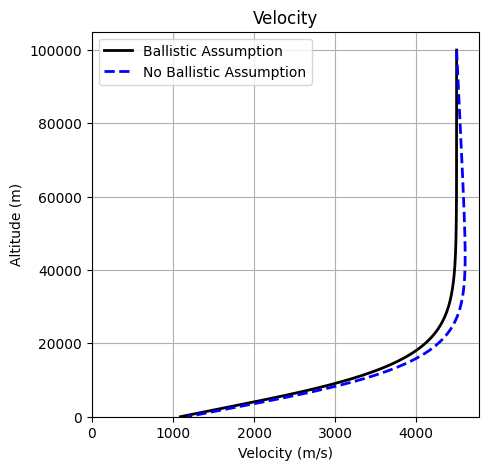

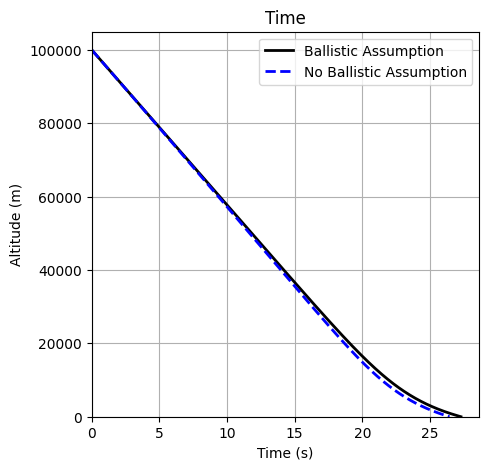

In [252]:
figSizeDefined = (5,5)

plt.figure(figsize=figSizeDefined)
plt.plot(velocityArrayB, heightArrayB, linewidth=2, linestyle='-', color='black', label='Ballistic Assumption')
plt.plot(velocityArrayNB, heightArrayNB, linewidth=2, linestyle='--', color='blue', label='No Ballistic Assumption')
plt.ylim(0)
plt.xlim(0)
plt.legend()
plt.title('Velocity')
plt.ylabel('Altitude (m)')
plt.xlabel('Velocity (m/s)')
plt.grid()
plt.show()

plt.figure(figsize=figSizeDefined)
plt.plot(timeArrayB, heightArrayB, linewidth=2, linestyle='-', color='black', label='Ballistic Assumption')
plt.plot(timeArrayNB, heightArrayNB, linewidth=2, linestyle='--', color='blue', label='No Ballistic Assumption')
plt.ylim(0)
plt.xlim(0)
plt.legend()
plt.title('Time')
plt.ylabel('Altitude (m)')
plt.xlabel('Time (s)')
plt.grid()
plt.show()

The difference in the plots is caused by the velocity update function.

The assumption for ballistic trajectory is to neglect the effects of gamma since **W*sin(gamma) << D**.

Drag dominates for the ballistic assumption resulting in the difference in the two plots.

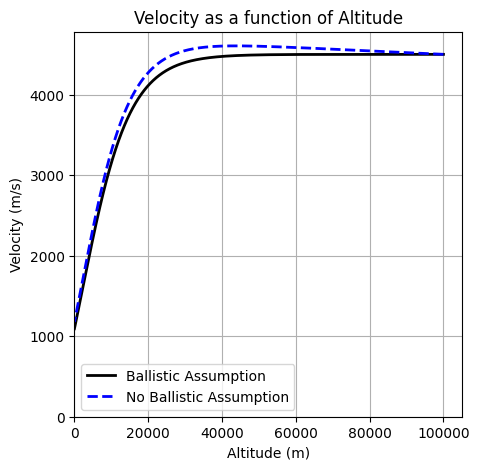

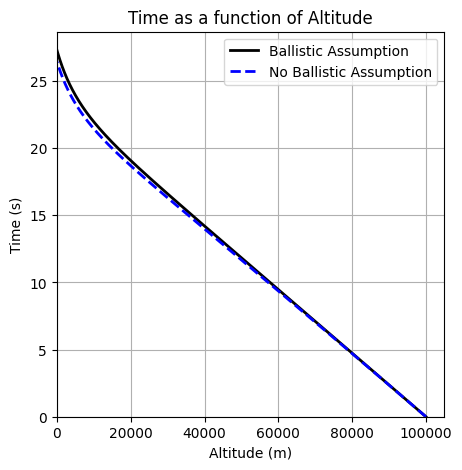

In [253]:
plt.figure(figsize=figSizeDefined)
plt.plot(heightArrayB, velocityArrayB, linewidth=2, linestyle='-', color='black', label='Ballistic Assumption')
plt.plot(heightArrayNB, velocityArrayNB, linewidth=2, linestyle='--', color='blue', label='No Ballistic Assumption')
plt.ylim(0)
plt.xlim(0)
plt.legend()
plt.title('Velocity as a function of Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Velocity (m/s)')
plt.grid()
plt.show()

plt.figure(figsize=figSizeDefined)
plt.plot(heightArrayB, timeArrayB, linewidth=2, linestyle='-', color='black', label='Ballistic Assumption')
plt.plot(heightArrayNB, timeArrayNB, linewidth=2, linestyle='--', color='blue', label='No Ballistic Assumption')
plt.ylim(0)
plt.xlim(0)
plt.legend()
plt.title('Time as a function of Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

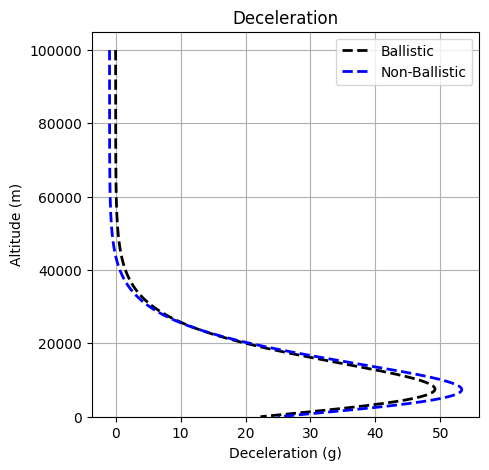

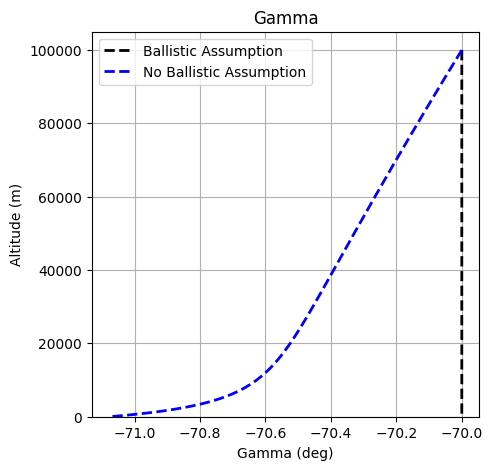

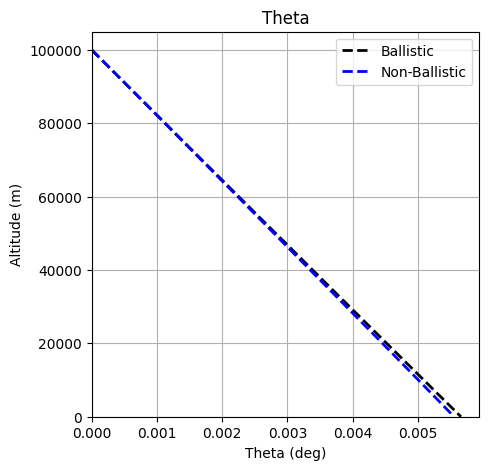

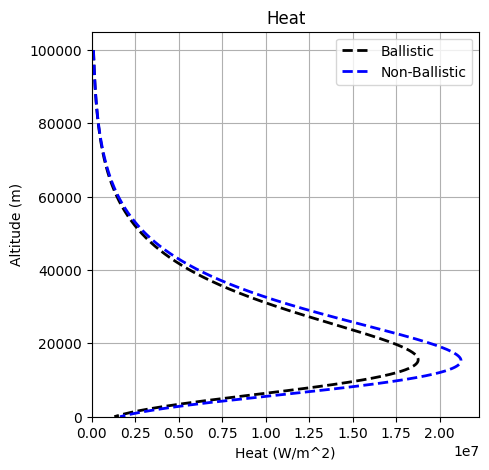

In [254]:
#Extra plots
plt.figure(figsize=figSizeDefined)
plt.plot(decelerationArrayB, heightArrayB, linewidth=2, linestyle='--', color='black', label='Ballistic')
plt.plot(decelerationArrayNB, heightArrayNB, linewidth=2, linestyle='--', color='blue', label='Non-Ballistic')
plt.ylim(0)
#plt.xlim(0)
plt.legend()
plt.title('Deceleration')
plt.ylabel('Altitude (m)')
plt.xlabel('Deceleration (g)')
plt.grid()
plt.show()


plt.figure(figsize=figSizeDefined)
plt.plot(gammaArrayB, heightArrayB, linewidth=2, linestyle='--', color='black', label='Ballistic Assumption')
plt.plot(gammaArrayNB, heightArrayNB, linewidth=2, linestyle='--', color='blue', label='No Ballistic Assumption')
plt.ylim(0)
#plt.xlim(0)
plt.legend()
plt.title('Gamma')
plt.ylabel('Altitude (m)')
plt.xlabel('Gamma (deg)')
plt.grid()
plt.show()


plt.figure(figsize=figSizeDefined)
plt.plot(thetaArrayB, heightArrayB, linewidth=2, linestyle='--', color='black', label='Ballistic')
plt.plot(thetaArrayNB, heightArrayNB, linewidth=2, linestyle='--', color='blue', label='Non-Ballistic')
plt.ylim(0)
plt.xlim(0)
plt.legend()
plt.title('Theta')
plt.ylabel('Altitude (m)')
plt.xlabel('Theta (deg)')
plt.grid()
plt.show()


plt.figure(figsize=figSizeDefined)
plt.plot(heatArrayB, heightArrayB, linewidth=2, linestyle='--', color='black', label='Ballistic')
plt.plot(heatArrayNB, heightArrayNB, linewidth=2, linestyle='--', color='blue', label='Non-Ballistic')
plt.ylim(0)
plt.xlim(0)
plt.legend()
plt.title('Heat')
plt.ylabel('Altitude (m)')
plt.xlabel('Heat (W/m^2)')
plt.grid()
plt.show()